**Process:**
* Load and check data
* Data preprocess (2 datasets)
* Answer each question (6 in total)
 
**Notations:**

*stock.sas7bdat*
* PERMNO: a 5-digit firm identifier
* DATE: last trading day of the month, SAS format yymmddn8.
* COMNAM: company name
* EXCHCD: 1: NYSE, 2: AMEX, 3: NASDAQ
* SICCD: 4 digit SIC code
* PRC: closing price
* RET: monthly return
* SHROUT: shares outstanding in thousand shares

*ff3.sas7bdat*
* DATE: last trading day of the month
* SMB: small-minus-big return
* HML: high-minus-low return
* MKTRF: excess return on the market
* RF: risk-free rate
* UMD: momentum factor

In [1]:
# import packages
import pandas as pd
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from scipy.stats import t, f
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load and check data

In [2]:
# load data (result from Homework 1)
small_alpha_return = pd.read_csv("small_alpha_return.csv")
big_alpha_return = pd.read_csv("big_alpha_return.csv")

# select time frame we want
small_alpha_return = small_alpha_return[(small_alpha_return.DATE > "2008-01-01")]
big_alpha_return = big_alpha_return[(big_alpha_return.DATE > "2008-01-01")]

# create rsik premium column
small_alpha_return["RIRF"] = small_alpha_return["VWPRet"] - small_alpha_return["RF"]
big_alpha_return["RIRF"] = big_alpha_return["VWPRet"] - big_alpha_return["RF"]

In [3]:
small_alpha_return.head()

,DATE,VWPRet,SMB,HML,MKTRF,RF,UMD,RIRF
83,2008-01-31,-0.143762,-0.0089,0.0365,-0.0636,0.0021,-0.0789,-0.145862
84,2008-02-29,-0.064606,-0.0023,-0.0095,-0.0309,0.0013,0.0614,-0.065906
85,2008-03-31,0.052088,0.0094,-0.0015,-0.0093,0.0017,0.0410,0.050388
86,2008-04-30,0.078511,-0.0164,-0.0096,0.0460,0.0018,-0.0020,0.076711
87,2008-05-30,0.004956,0.0322,-0.0138,0.0186,0.0018,0.0321,0.003156


In [4]:
big_alpha_return.head()

,DATE,VWPRet,SMB,HML,MKTRF,RF,UMD,RIRF
83,2008-01-31,-0.067338,-0.0089,0.0365,-0.0636,0.0021,-0.0789,-0.069438
84,2008-02-29,-0.006674,-0.0023,-0.0095,-0.0309,0.0013,0.0614,-0.007974
85,2008-03-31,0.012463,0.0094,-0.0015,-0.0093,0.0017,0.0410,0.010763
86,2008-04-30,0.045537,-0.0164,-0.0096,0.0460,0.0018,-0.0020,0.043737
87,2008-05-30,0.063781,0.0322,-0.0138,0.0186,0.0018,0.0321,0.061981


# Answer each question (6 in total)

### 1. One argument of the existence of the CAPM alpha is the explanatory power of the CAPM, or lack thereof. You might have an excellent performance in your portfolio in the first homework because you take on higher risks that can only be captured by SMB or HML, or even UMD, but not by the market factor. Please examine whether your portfolio alpha is still significant with equation (1) and (2) to compare the intercept to the alpha with the CAPM. Use the original sample period to estimate the beta of the firms in homework 1 (2008-2012) and test for both high- and low-alpha portfolios and see if the alphas are still as large/small as they were. (Note: make a table for the parameters of different models and discuss.)

In [5]:
# define function to run regression
def run_regression(x, y):
    X = add_constant(x)
    Y = y
    model = OLS(Y, X, missing="drop")
    result = model.fit()
    params = pd.DataFrame(result.params).T
    t_value = pd.DataFrame(result.tvalues).T
    t_value.columns = result.tvalues.index + "_t_value"
    p_value = pd.DataFrame(result.pvalues).T
    p_value.columns = result.pvalues.index + "_p_value"
    std_err = pd.DataFrame(result.bse).T
    std_err.columns = result.bse.index + "_std_error"
    rsquared = pd.DataFrame([result.rsquared])
    rsquared.columns = ["R_squared"]
    rsquared_adj = pd.DataFrame([result.rsquared_adj])
    rsquared_adj.columns = ["R_squared_adj"]
    f_value = pd.DataFrame([result.fvalue])
    f_value.columns = ["F_value"]
    f_pvalue = pd.DataFrame([result.f_pvalue])
    f_pvalue.columns = ["F_p_value"]
    counts = pd.DataFrame([len(X)])
    counts.columns = ["counts"]
    params_num = pd.DataFrame([len(result.params)])
    params_num.columns = ["params_num"]
    
    result = params.join(t_value).join(p_value).join(std_err)\
    .join(rsquared).join(rsquared_adj).join(f_value).join(f_pvalue)\
    .join(counts).join(params_num)
    result.columns = list(map(lambda x: x.replace("const", "Alpha"), result.columns))
    result.columns = list(map(lambda x: x.replace("MKTRF", "Beta"), result.columns))
    return result.T

**Result of small $\alpha$ portfolio**

In [26]:
# prepare data (select data between 2008~2012)
small_alpha_return_early = small_alpha_return.iloc[:60, ]

# run regression according to dfiierent model
CAPM_small_alpha_early = run_regression(small_alpha_return_early["MKTRF"],
                                        small_alpha_return_early["RIRF"])
CAPM_small_alpha_early.columns = ["CAPM"]

Fama_French_small_alpha_early = run_regression(small_alpha_return_early[["MKTRF", "SMB", "HML"]],
                                               small_alpha_return_early["RIRF"])
Fama_French_small_alpha_early.columns = ["Fama_French"]

Carhart_small_alpha_early = run_regression(small_alpha_return_early[["MKTRF", "SMB", "HML", "UMD"]],
                                           small_alpha_return_early["RIRF"])
Carhart_small_alpha_early.columns = ["Carhart"]

# create index to select from regression result
alpha_index = ['Alpha', 'Alpha_p_value']

# select columns according to above index
CAPM_small_alpha_early_result = CAPM_small_alpha_early.T[alpha_index]
Fama_French_small_alpha_early_result = Fama_French_small_alpha_early.T[alpha_index]
Carhart_small_alpha_early_result = Carhart_small_alpha_early.T[alpha_index]

# combine result
pd.concat([CAPM_small_alpha_early_result,
           Fama_French_small_alpha_early_result,
           Carhart_small_alpha_early_result], axis=0)

,Alpha,Alpha_p_value
CAPM,-0.034489,0.000125
Fama_French,-0.035018,0.000144
Carhart,-0.035398,0.000147


**Result of big $\alpha$ portfolio**

In [27]:
# prepare data (select data between 2008~2012)
big_alpha_return_early = big_alpha_return.iloc[:60, ]

# run regression according to dfiierent model
CAPM_big_alpha_early = run_regression(big_alpha_return_early["MKTRF"],
                                        big_alpha_return_early["RIRF"])
CAPM_big_alpha_early.columns = ["CAPM"]

Fama_French_big_alpha_early = run_regression(big_alpha_return_early[["MKTRF", "SMB", "HML"]],
                                               big_alpha_return_early["RIRF"])
Fama_French_big_alpha_early.columns = ["Fama_French"]

Carhart_big_alpha_early = run_regression(big_alpha_return_early[["MKTRF", "SMB", "HML", "UMD"]],
                                           big_alpha_return_early["RIRF"])
Carhart_big_alpha_early.columns = ["Carhart"]

# select columns according to above index
CAPM_big_alpha_early_result = CAPM_big_alpha_early.T[alpha_index]
Fama_French_big_alpha_early_result = Fama_French_big_alpha_early.T[alpha_index]
Carhart_big_alpha_early_result = Carhart_big_alpha_early.T[alpha_index]

# combine result
pd.concat([CAPM_big_alpha_early_result,
           Fama_French_big_alpha_early_result,
           Carhart_big_alpha_early_result], axis=0)

,Alpha,Alpha_p_value
CAPM,0.025507,0.023981
Fama_French,0.021601,0.050733
Carhart,0.020572,0.063140


### 2. Which is the best model to explain your portfolio returns from 2008 to 2012? FF-3, Carhart 4-factor or the CAPM? (Note: you should judge the model performance by goodness-of-fit and parameter significance, not by alpha alone. Since these models are nested, please use F-tests to compare them.)

**Create index to select from regression result**

In [8]:
# index for goodness-of-fit
R_F_index = ['R_squared', 'R_squared_adj', 'F_value', 'F_p_value']

# index for parameter significance
CAPM_index = ['Alpha', 'Beta',
              'Alpha_p_value', 'Beta_p_value']

Fama_French_index = ['Alpha', 'Beta', 'SMB', 'HML',
                     'Alpha_p_value', 'Beta_p_value', 'SMB_p_value', 'HML_p_value']

Carhart_index = ['Alpha', 'Beta', 'SMB', 'HML', 'UMD',
                 'Alpha_p_value', 'Beta_p_value', 'SMB_p_value', 'HML_p_value', 'UMD_p_value']

**Define function for F testing**

In [14]:
def f_test(old_data, new_data):
    old_data = old_data.T
    new_data = new_data.T
    numerator = (new_data["R_squared"][0] - old_data["R_squared"][0])
    numerator_df = new_data["params_num"][0] - old_data["params_num"][0]
    denominator = (1 - new_data["R_squared"][0])
    denominator_df = new_data["counts"][0] - new_data["params_num"][0]
    numerator = (numerator/numerator_df)
    denominator = (denominator/denominator_df)

    if numerator > denominator:
        F_value = numerator/denominator
        F_p_value = f.sf(abs(F_value), dfn=numerator_df, dfd=denominator_df)
    else:
        F_value = denominator/numerator
        F_p_value = f.sf(abs(F_value), dfn=denominator_df, dfd=numerator_df)

    result = pd.DataFrame([F_value, F_p_value]).T
    result.columns = ["F_value", "F_p_value"]
    return result

**Deal with small $\alpha$**

**Overview of model's goodness-of-fit: R-squared / F-statistics**

In [18]:
pd.concat([CAPM_small_alpha_early.T[R_F_index],
           Fama_French_small_alpha_early.T[R_F_index],
           Carhart_small_alpha_early.T[R_F_index]])

,R_squared,R_squared_adj,F_value,F_p_value
CAPM,0.450098,0.440617,47.473292,4.482638e-09
Fama_French,0.457251,0.428175,15.726156,1.546199e-07
Carhart,0.459656,0.420358,11.696740,6.071153e-07


**Investigate parameter significance**

In [19]:
pd.concat([CAPM_small_alpha_early.T[CAPM_index],
           Fama_French_small_alpha_early.T[Fama_French_index],
           Carhart_small_alpha_early.T[Carhart_index]])

,Alpha,Alpha_p_value,Beta,Beta_p_value,HML,HML_p_value,SMB,SMB_p_value,UMD,UMD_p_value
CAPM,-0.034489,0.000125,1.032835,4.482638e-09,NaN,NaN,NaN,NaN,NaN,NaN
Fama_French,-0.035018,0.000144,0.945937,3.007345e-06,0.165070,0.573300,0.257006,0.540815,NaN,NaN
Carhart,-0.035398,0.000147,0.919005,1.246506e-05,0.118662,0.701517,0.266097,0.529873,-0.077029,0.622758


**Investigate the "incremental" contribution of explantory variable**

From the slide teacher gave:
![slide](https://i.imgur.com/oeJoDos.png)
We are going to use the second equation (R-squared method) to run F-test.

1. CAPM vs Fama French → test "SMB", "HML"

In [67]:
f_test(CAPM_small_alpha_early, Fama_French_small_alpha_early)

2.0
56.0


,F_value,F_p_value
0,2.709768,0.30693


2. Fama French vs Carhart → test "UMD"

In [68]:
f_test(Fama_French_small_alpha_early, Carhart_small_alpha_early)

1.0
55.0


,F_value,F_p_value
0,4.085603,0.377242


3. CAPM vs Carhart → test "SMB", "HML", "UMD"

In [69]:
f_test(CAPM_small_alpha_early, Carhart_small_alpha_early)

3.0
55.0


,F_value,F_p_value
0,3.083633,0.19223


**Deal with big $\alpha$**

**Overview of model's goodness-of-fit: R-squared / F-statistics**

In [10]:
pd.concat([CAPM_big_alpha_early.T[R_F_index],
          Fama_French_big_alpha_early.T[R_F_index],
          Carhart_big_alpha_early.T[R_F_index]])

,R_squared,R_squared_adj,F_value,F_p_value
CAPM,0.281454,0.269065,22.718580,0.000013
Fama_French,0.345431,0.310364,9.850808,0.000026
Carhart,0.358798,0.312165,7.694112,0.000054


**Investigate parameter significance**

In [11]:
pd.concat([CAPM_big_alpha_early.T[CAPM_index],
          Fama_French_big_alpha_early.T[Fama_French_index],
          Carhart_big_alpha_early.T[Carhart_index]])

,Alpha,Alpha_p_value,Beta,Beta_p_value,HML,HML_p_value,SMB,SMB_p_value,UMD,UMD_p_value
CAPM,0.025507,0.023981,0.937252,0.000013,NaN,NaN,NaN,NaN,NaN,NaN
Fama_French,0.021601,0.050733,0.774074,0.001363,-0.219426,0.552536,1.205368,0.025807,NaN,NaN
Carhart,0.020572,0.063140,0.701205,0.004911,-0.344993,0.374126,1.229966,0.023074,-0.208416,0.288931


**Investigate the "incremental" contribution of explantory variable**

1. CAPM vs Fama French → test "SMB" & "HML"

In [15]:
f_test(CAPM_big_alpha_early, Fama_French_big_alpha_early)

,F_value,F_p_value
0,2.73667,0.073457


2. Fama French vs Carhart → test "UMD"

In [16]:
f_test(Fama_French_big_alpha_early, Carhart_big_alpha_early)

,F_value,F_p_value
0,1.146637,0.288931


3. CAPM vs Carhart → test "SMB", "HML", "UMD"

In [17]:
f_test(CAPM_big_alpha_early, Carhart_big_alpha_early)

,F_value,F_p_value
0,2.211436,0.097052


### 3. A lot of you might find the behavior of your portfolio coefficients are very different before and after the portfolio construction date (the end of 2012). Please use your best model at explaining your two portfolios to make your argument (whichever is better in the previous question should be used here) about the existence of a structural change with your portfolio (i.e. you have significant changes in regression parameters).

**First,we need to test whether two population variance are the same or not, if both variance are the same then we can run chow test.**

**Deal with small $\alpha$**

In [61]:
# prepare data (select data between 2013~2017)
small_alpha_return_later = small_alpha_return.iloc[-60:, ]

small_alpha_return_early = small_alpha_return_early.copy()
small_alpha_return_early["D"] = 1

small_alpha_return_later = small_alpha_return_later.copy()
small_alpha_return_later["D"] = 0

small_alpha_return = pd.concat([small_alpha_return_early, small_alpha_return_later])
small_alpha_return["DMKTRF"] = small_alpha_return["MKTRF"] * small_alpha_return["D"]
small_alpha_return["DSMB"] = small_alpha_return["SMB"] * small_alpha_return["D"]
small_alpha_return["DHML"] = small_alpha_return["HML"] * small_alpha_return["D"]
small_alpha_return["DUMD"] = small_alpha_return["UMD"] * small_alpha_return["D"]

# run regression
small_alpha = run_regression(small_alpha_return[["MKTRF", "SMB", "HML", "UMD"]],
                             small_alpha_return["RIRF"])

small_alpha_dummy = run_regression(small_alpha_return[["D", "MKTRF", "SMB", "HML", "UMD", "DMKTRF", "DSMB", "DHML", "DUMD"]],
                                   small_alpha_return["RIRF"])

# run f test
f_test(small_alpha, small_alpha_dummy)

,F_value,F_p_value
0,3.608661,0.004632


**Deal with big $\alpha$**

In [70]:
# prepare data (select data between 2013~2017)
big_alpha_return_later = big_alpha_return.iloc[-60:, ]

big_alpha_return_early = big_alpha_return_early.copy()
big_alpha_return_early["D"] = 1

big_alpha_return_later = big_alpha_return_later.copy()
big_alpha_return_later["D"] = 0

big_alpha_return = pd.concat([big_alpha_return_early, big_alpha_return_later])
big_alpha_return["DMKTRF"] = big_alpha_return["MKTRF"] * big_alpha_return["D"]
big_alpha_return["DSMB"] = big_alpha_return["SMB"] * big_alpha_return["D"]
big_alpha_return["DHML"] = big_alpha_return["HML"] * big_alpha_return["D"]
big_alpha_return["DUMD"] = big_alpha_return["UMD"] * big_alpha_return["D"]

# run regression
big_alpha = run_regression(big_alpha_return[["MKTRF", "SMB", "HML", "UMD"]],
                           big_alpha_return["RIRF"])

big_alpha_dummy = run_regression(big_alpha_return[["D", "MKTRF", "SMB", "HML", "UMD", "DMKTRF", "DSMB", "DHML", "DUMD"]],
                                 big_alpha_return["RIRF"])

# run f test
f_test(big_alpha, big_alpha_dummy)

5.0
110.0


,F_value,F_p_value
0,1.39594,0.231376


### 4. Please analyze the risk premium of your long-short strategy with these models. Show the parameters before and after the portfolio construction date (i.e. 2008-2012 and 2013-2017).

In [84]:
# prepare data for long-short portfolio
long_short_return = small_alpha_return[['DATE', 'RF', 'MKTRF', 'HML', 'SMB', 'UMD']]
long_short_return = long_short_return.copy()
long_short_return["VWPRet"] = big_alpha_return["VWPRet"] - small_alpha_return["VWPRet"]
long_short_return["RIRF"] = long_short_return["VWPRet"] - long_short_return["RF"]

**Deal with 2008-2012**

In [99]:
# prepare data (select data between 2008~2012)
long_short_return_early = long_short_return.iloc[:60, ]

# run regression according to dfiierent model
CAPM_long_short_early = run_regression(long_short_return_early["MKTRF"],
                                       long_short_return_early["RIRF"])
CAPM_long_short_early.columns = ["CAPM"]

Fama_French_long_short_early = run_regression(long_short_return_early[["MKTRF", "SMB", "HML"]],
                                              long_short_return_early["RIRF"])
Fama_French_long_short_early.columns = ["Fama_French"]

Carhart_long_short_early = run_regression(long_short_return_early[["MKTRF", "SMB", "HML", "UMD"]],
                                          long_short_return_early["RIRF"])
Carhart_long_short_early.columns = ["Carhart"]

# create index to select from regression result
alpha_index = ['Alpha', 'Alpha_p_value']

# select columns according to above index
CAPM_long_short_early_result = CAPM_long_short_early.T[alpha_index]
Fama_French_long_short_early_result = Fama_French_long_short_early.T[alpha_index]
Carhart_long_short_early_result = Carhart_long_short_early.T[alpha_index]

# combine result
long_short_early_result = pd.concat([CAPM_long_short_early_result,
                          Fama_French_long_short_early_result,
                          Carhart_long_short_early_result], axis=0)

long_short_early_result.columns = ['Alpha(2008~2012)', 'Alpha_p_value(2008~2012)']

**Deal with 2013~2017**

In [100]:
# prepare data (select data between 2008~2012)
long_short_return_later = long_short_return.iloc[-60:, ]

# run regression according to dfiierent model
CAPM_long_short_later = run_regression(long_short_return_later["MKTRF"],
                                        long_short_return_later["RIRF"])
CAPM_long_short_later.columns = ["CAPM"]

Fama_French_long_short_later = run_regression(long_short_return_later[["MKTRF", "SMB", "HML"]],
                                               long_short_return_later["RIRF"])
Fama_French_long_short_later.columns = ["Fama_French"]

Carhart_long_short_later = run_regression(long_short_return_later[["MKTRF", "SMB", "HML", "UMD"]],
                                           long_short_return_later["RIRF"])
Carhart_long_short_later.columns = ["Carhart"]

# create index to select from regression result
alpha_index = ['Alpha', 'Alpha_p_value']

# select columns according to above index
CAPM_long_short_later_result = CAPM_long_short_later.T[alpha_index]
Fama_French_long_short_later_result = Fama_French_long_short_later.T[alpha_index]
Carhart_long_short_later_result = Carhart_long_short_later.T[alpha_index]

# combine result
long_short_later_result = pd.concat([CAPM_long_short_later_result,
                          Fama_French_long_short_later_result,
                          Carhart_long_short_later_result], axis=0)

long_short_later_result.columns = ['Alpha(2013~2017)', 'Alpha_p_value(2013~2017)']

**Result**

In [107]:
long_short_early_result.join(long_short_later_result)

,Alpha(2008~2012),Alpha_p_value(2008~2012),Alpha(2013~2017),Alpha_p_value(2013~2017)
CAPM,0.059676,0.000070,0.009277,0.385905
Fama_French,0.056306,0.000181,0.006734,0.487241
Carhart,0.055653,0.000245,0.010143,0.293572


### 5. We often use the CAPM or FF-3 model or even four-factor model to estimate the cost-of-equity of a firm or to forecast the return on a security or a portfolio. Please use the portfolio return data from 2013 to 2017 for an out-of-sample test. Which model do you think is better for the job? To solve the problem, you need to calculate the prediction error by
![fromnt](https://i.imgur.com/AgcKjgL.png)
![back](https://i.imgur.com/hKJzgUE.png)

**Define class for ols model (calculate MSPE):**

In [228]:
class ols_model():
    def __init__(self, x, y):
        self.x = add_constant(x)
        self.y = y
        
    def fit(self):
        self.model = OLS(self.y, self.x, missing="drop")
        self.result = self.model.fit()
    
    def calculate_MSPE(self, input_x, rf, correct_y):
        input_x = add_constant(input_x).values
        self.fit()
        self.predict_y = self.result.predict(input_x) + rf
        self.correct_y = correct_y
        residual_squared =  (self.predict_y - self.correct_y) ** 2
        self.MSPE = (1/len(input_x)) * sum(residual_squared)
        return self.MSPE

**Deal with small $\alpha$**

In [219]:
# run with CAPM model
CAPM_model = ols_model(small_alpha_return_early[["MKTRF"]],
                       small_alpha_return_early[["RIRF"]])

CAPM_MSPE = CAPM_model.calculate_MSPE(small_alpha_return_later[["MKTRF"]],
                                      small_alpha_return_later["RF"],
                                      small_alpha_return_later["VWPRet"])

# run with Fama French model
Fama_French_model = ols_model(small_alpha_return_early[["MKTRF", "SMB", "HML"]],
                              small_alpha_return_early[["RIRF"]])

Fama_French_MSPE = Fama_French_model.calculate_MSPE(small_alpha_return_later[["MKTRF", "SMB", "HML"]],
                                                    small_alpha_return_later["RF"],
                                                    small_alpha_return_later["VWPRet"])

# run with Carhart model
Carhart_model = ols_model(small_alpha_return_early[["MKTRF", "SMB", "HML", "UMD"]],
                          small_alpha_return_early[["RIRF"]])

Carhart_MSPE = Carhart_model.calculate_MSPE(small_alpha_return_later[["MKTRF", "SMB", "HML", "UMD"]],
                                            small_alpha_return_later["RIRF"],
                                            small_alpha_return_later["VWPRet"])

# combine result
result = pd.DataFrame([CAPM_MSPE, Fama_French_MSPE, Carhart_MSPE]).T
result.columns = ["CAPM_MSPE", "Fama_French_MSPE", "Carhart_MSPE"]
result

,CAPM_MSPE,Fama_French_MSPE,Carhart_MSPE
0,0.003379,0.003235,0.001453


In [287]:
CAPM_model_residual = pd.DataFrame([CAPM_model.predict_y - CAPM_model.correct_y]).T
CAPM_model_residual.rename(columns={0: "CAPM"}, inplace=True)
Fama_French_model_residual = pd.DataFrame([Fama_French_model.predict_y - Fama_French_model.correct_y]).T
Fama_French_model_residual.rename(columns={0: "Fama_French"}, inplace=True)
Carhart_model_residual = pd.DataFrame([Carhart_model.predict_y - Carhart_model.correct_y]).T
Carhart_model_residual.rename(columns={0: "Carhart"}, inplace=True)

In [296]:
residual = pd.concat([CAPM_model_residual,
                      Fama_French_model_residual,
                      Carhart_model_residual], axis=1)

residual.index = small_alpha_return_later.DATE.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

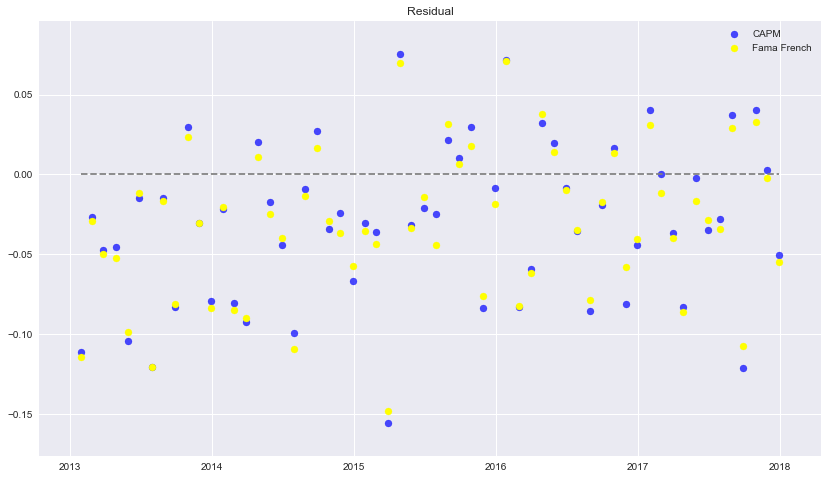

In [312]:
plt.style.use("seaborn")
plt.figure(figsize=(14, 8))

plt.scatter(residual.index, residual.CAPM, c="blue", label="CAPM", alpha=0.7)
plt.scatter(residual.index, residual.Fama_French, c="yellow", label="Fama French", alpha=1)
#plt.scatter(residual.index, residual.Carhart, c="red", label="Carhart", alpha=0.2)

plt.plot(residual.index, [0]*len(residual), ls="--", c="grey")
plt.title("Residual")
plt.legend();

In [199]:
pd.concat([small_alpha_return.iloc[0],
           small_alpha_return.iloc[-1]], axis=1).T

,D,DATE,DHML,DMKTRF,DSMB,DUMD,HML,MKTRF,RF,RIRF,SMB,UMD,VWPRet
83,1,2008-01-31,0.0365,-0.0636,-0.0089,-0.0789,0.0365,-0.0636,0.0021,-0.145862,-0.0089,-0.0789,-0.143762
202,0,2017-12-29,0,0,-0,-0,0.0014,0.0106,0.0009,0.0270508,-0.0126,-0.016,0.0279508


In [166]:
X = small_alpha_return_early[["MKTRF", "SMB", "HML"]]
Y = small_alpha_return_early["RIRF"]
model = ols_model(X, Y)
a = model.predict(small_alpha_return_later[["MKTRF", "SMB", "HML"]])

### 6. How do you examine if there exists collinearity between those risk factors in equation (2)? (Hint: there’s no collinearity) Please use 2008 to 2012 data to verify that.

**Reference:**
1. http://efavdb.com/interpret-linear-regression/